In [2]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import numpy as np

import gym
import d4rl

from rlkit.torch.networks import Mlp
import seaborn as sns
import matplotlib.pyplot as plt

import matplotlib
matplotlib.rcParams['figure.figsize'] = (15, 10)


In [3]:
def get_bonus(obs, actions, network, target_network):
    data = torch.cat((obs, actions), dim=1)
    # print('size of data:{}'.format(data.size()))
    
    with torch.no_grad():
        bonus = abs(network(data) - target_network(data))
    # print('size of bonus:{}'.format(bonus.size()))
    
    return bonus

In [4]:
def get_bonus_random_actions(obs, actions, network, target_network):
    action_shape = actions.shape[0]
    obs_shape = obs.shape[0]
    num_repeat = int (action_shape / obs_shape)
    obs_temp = obs.unsqueeze(1).repeat(1, num_repeat, 1).view(obs.shape[0] * num_repeat, obs.shape[1])
    # feed to the bonus networks
    data = torch.cat((obs_temp, actions), dim=1)
    with torch.no_grad():
        bonus = abs(network(data) - target_network(data))
    # reshape
    bonus = bonus.view(obs.shape[0], num_repeat, 1)
    return bonus

In [5]:
def load_models(model_name):
    
    M = 64
    network = Mlp(
        input_size=obs_dim + action_dim,
        output_size=1,
        hidden_sizes=[M, M],
    )

    target_network = Mlp(
    input_size=obs_dim + action_dim,
    output_size=1,
    hidden_sizes=[M, M],
    )
    
    path = '../models/{}'.format(model_name)
    checkpoint = torch.load(path, map_location='cpu')
    network.load_state_dict(checkpoint['network_state_dict'])
    target_network.load_state_dict(checkpoint['target_state_dict'])

    print('Loading model: {}'.format(path))
    
    return network, target_network

In [6]:
num_bins = 100
num_random = 10

# Halfcheetah

In [8]:
env_name = 'halfcheetah-medium-v0'

env = gym.make(env_name)
obs_dim = env.observation_space.low.size
action_dim = env.action_space.low.size

print(obs_dim)
print(action_dim)

dataset = env.get_dataset()
obs = torch.from_numpy(dataset['observations'])
actions = torch.from_numpy(dataset['actions'])
rewards = dataset['rewards']


17
6


In [9]:
model_name = 'Nov-03-2020_1648_halfcheetah-medium-v0.pt'
network_1, target_network_1 = load_models(model_name)
bonus_1 = get_bonus(obs, actions, network_1, target_network_1).detach().cpu().numpy()

Loading model: ../models/Nov-03-2020_1648_halfcheetah-medium-v0.pt


In [10]:
random_actions = torch.FloatTensor(actions.shape[0] * num_random, actions.shape[-1]).uniform_(-1, 1)
bonus_random_1 = get_bonus_random_actions(obs, random_actions, network_1, target_network_1).detach().cpu().numpy()
bonus_random_1_mean = np.mean(bonus_random_1, axis=1)

In [11]:
ind = np.random.permutation(actions.shape[0])
shuffled_actions = actions[ind]

bonus_shuffled_1 = get_bonus(obs, shuffled_actions, network_1, target_network_1).detach().cpu().numpy()

In [12]:
reward_mean = np.mean(rewards)
delta_bonus_1 = abs(bonus_random_1_mean - bonus_1).squeeze(1)

delta_bonus_1_mean = np.mean(delta_bonus_1)
b_0 = 0.25
print('mean reward:{}, delta_bonus:{}'.format(reward_mean,delta_bonus_1_mean))
rho1 = reward_mean / delta_bonus_1_mean
beta1 = b_0 * rho1
print('rho1:{0:0.2g}, beta1:{1:.2g}'.format(rho1, beta1))


rho2 = np.mean(rewards / np.clip(delta_bonus_1, 1e-9, 1e9))
beta2 = b_0 * rho2
print('rho2:{0:.2g}, beta2:{1:.2g}'.format(rho2, beta2))

beta = beta1

mean reward:3.9530251026153564, delta_bonus:0.00021603186905849725
rho1:1.8e+04, beta1:4.6e+03
rho2:1.7e+05, beta2:4.2e+04


In [14]:
for b_0 in [0.1, 0.2, 0.3, 0.4 , 0.5, 0.6, 0.7]:
    print('beta1:{:.2g}'.format(b_0 * rho1))

beta1:1.8e+03
beta1:3.7e+03
beta1:5.5e+03
beta1:7.3e+03
beta1:9.1e+03
beta1:1.1e+04
beta1:1.3e+04


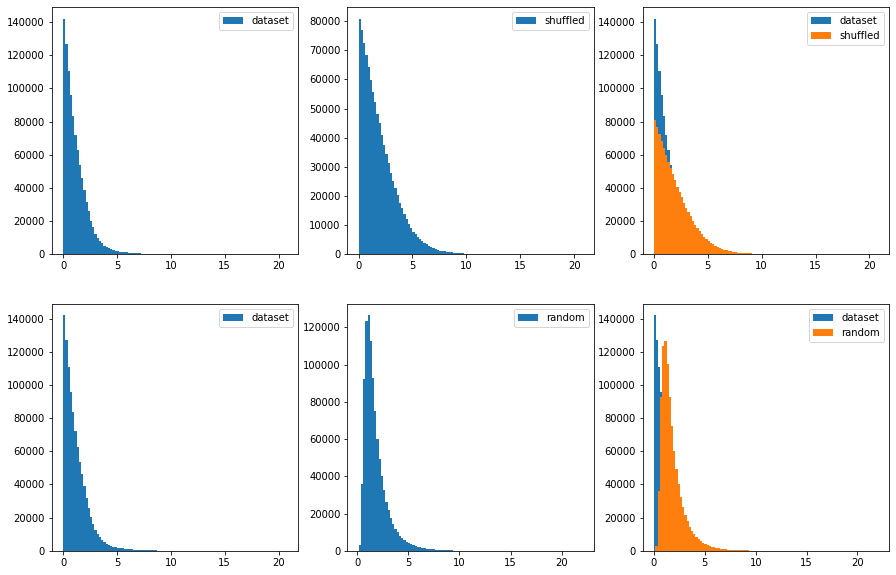

In [11]:
# ax1, ax2, ax3, ax4, ax5, ax6 = plt.subplots(2, 3, figsize=(15, 5), sharey=True)

plt.subplot(2, 3, 1)
plt.hist(beta * bonus_1, bins = num_bins, label='dataset')
plt.legend()

plt.subplot(2, 3, 2)
plt.hist(beta * bonus_shuffled_1, bins = num_bins, label='shuffled')
plt.legend()

plt.subplot(2, 3, 3)
plt.hist(beta * bonus_1, bins = num_bins, label='dataset')
plt.hist(beta * bonus_shuffled_1, bins = num_bins, label='shuffled')
plt.legend(loc='upper right')


plt.subplot(2, 3, 4)
plt.hist(beta * bonus_1, bins = num_bins, label='dataset')
plt.legend()

plt.subplot(2, 3, 5)
plt.hist(beta * bonus_random_1_mean, bins = num_bins, label='random')
plt.legend()

plt.subplot(2, 3, 6)
plt.hist(beta * bonus_1, bins = num_bins, label='dataset')
plt.hist(beta * bonus_random_1_mean, bins = num_bins, label='random')
plt.legend(loc='upper right')

In [20]:
print(delta_bonus_1.shape)
print(bonus_1.squeeze(1).shape)
print(rewards.shape)

param_1 = delta_bonus_1 / np.clip(bonus_1.squeeze(1), 1e-9, 1e9)
param_2 = rewards / np.clip(bonus_1.squeeze(1), 1e-9, 1e9)
param_3 = rewards / np.clip(delta_bonus_1, 1e-9, 1e9)

(1000000,)
(1000000,)
(1000000,)


In [25]:
max(param_1)

343637.2

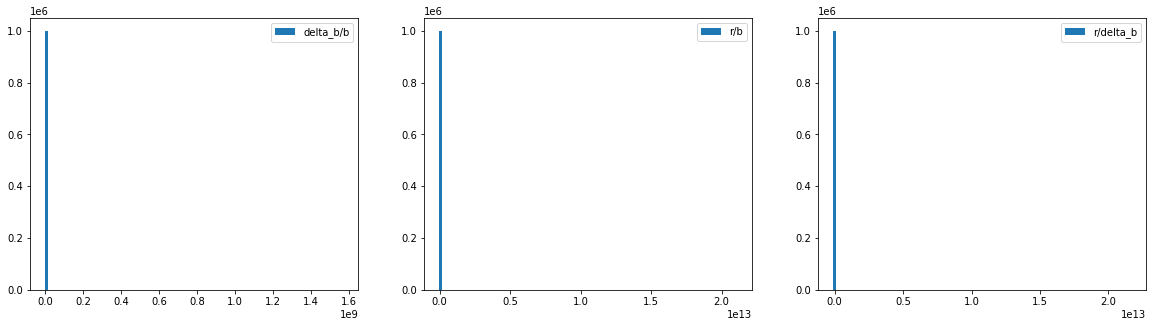

In [23]:
matplotlib.rcParams['figure.figsize'] = (20, 5)

plt.subplot(1, 3, 1)
plt.hist(beta * param_1, bins = num_bins, label='delta_b/b')
plt.legend()

plt.subplot(1, 3, 2)
plt.hist(beta * param_2, bins = num_bins, label='r/b')
plt.legend()

plt.subplot(1, 3, 3)
plt.hist(beta * param_3, bins = num_bins, label='r/delta_b')
plt.legend(loc='upper right')





In [ ]:
plt.hist(beta * bonus_1, bins = num_bins, label='dataset')
plt.hist(beta * bonus_random_1_mean, bins = num_bins, label='random')
plt.legend(loc='upper right')

## hopper-medium

In [ ]:
env_name = 'hopper-medium-v0'

env = gym.make(env_name)
obs_dim = env.observation_space.low.size
action_dim = env.action_space.low.size

print(obs_dim)
print(action_dim)

dataset = env.get_dataset()
obs = dataset['observations']
actions = dataset['actions']
rewards = dataset['rewards']

In [ ]:
model_name = 'Nov-09-2020_1517_hopper-medium-v0.pt'
network_1, target_network_1 = load_models(model_name)
bonus_1 = get_bonus(obs, actions, network_1, target_network_1).detach().cpu().numpy()

In [ ]:
plt.subplot(2, 3, 1)
plt.hist(beta * bonus_1, bins = num_bins, label='dataset')
plt.legend()

plt.subplot(2, 3, 2)
plt.hist(beta * bonus_shuffled_1, bins = num_bins, label='shuffled')
plt.legend()

plt.subplot(2, 3, 3)
plt.hist(beta * bonus_1, bins = num_bins, label='dataset')
plt.hist(beta * bonus_shuffled_1, bins = num_bins, label='shuffled')
plt.legend(loc='upper right')


plt.subplot(2, 3, 4)
plt.hist(beta * bonus_1, bins = num_bins, label='dataset')
plt.legend()

plt.subplot(2, 3, 5)
plt.hist(beta * bonus_random_1, bins = num_bins, label='random')
plt.legend()

plt.subplot(2, 3, 6)
plt.hist(beta * bonus_1, bins = num_bins, label='dataset')
plt.hist(beta * bonus_random_1, bins = num_bins, label='random')
plt.legend(loc='upper right')

# Walker2d-medium


In [15]:
env_name = 'walker2d-medium-v0'

env = gym.make(env_name)
obs_dim = env.observation_space.low.size
action_dim = env.action_space.low.size

print(obs_dim)
print(action_dim)
dataset = env.get_dataset()

obs = torch.from_numpy(dataset['observations'])
actions = torch.from_numpy(dataset['actions'])
rewards = dataset['rewards']

17
6


In [16]:
model_name_1 = 'Nov-19-2020_1043_walker2d-medium-v0.pt'
model_name_2 = 'Nov-19-2020_1357_walker2d-medium-v0.pt'
network_1, target_network_1 = load_models(model_name_1)
network_2, target_network_2 = load_models(model_name_2)



Loading model: ../models/Nov-19-2020_1043_walker2d-medium-v0.pt
Loading model: ../models/Nov-19-2020_1357_walker2d-medium-v0.pt


In [17]:
bonus_1 = get_bonus(obs, actions, network_1, target_network_1).detach().cpu().numpy()
bonus_2 = get_bonus(obs, actions, network_2, target_network_2).detach().cpu().numpy()

ind = np.random.permutation(actions.shape[0])
shuffled_actions = actions[ind]


bonus_shuffled_1 = get_bonus(obs, shuffled_actions, network_1, target_network_1).detach().cpu().numpy()
bonus_shuffled_2 = get_bonus(obs, shuffled_actions, network_2, target_network_2).detach().cpu().numpy()


In [18]:
random_actions = torch.FloatTensor(actions.shape[0] * num_random, actions.shape[-1]).uniform_(-1, 1)

bonus_random_1 = get_bonus_random_actions(obs, random_actions, network_1, target_network_1).detach().cpu().numpy()
bonus_random_1_mean = np.mean(bonus_random_1, axis=1)

bonus_random_2 = get_bonus_random_actions(obs, random_actions, network_2, target_network_2).detach().cpu().numpy()
bonus_random_2_mean = np.mean(bonus_random_1, axis=1)

In [19]:
reward_mean = np.mean(rewards)
delta_bonus_1 = abs(bonus_random_1_mean - bonus_1).squeeze(1)

delta_bonus_1_mean = np.mean(delta_bonus_1)
b_0 = 0.25
print('mean reward:{}, delta_bonus:{}'.format(reward_mean,delta_bonus_1_mean))
rho1 = reward_mean / delta_bonus_1_mean
beta1 = b_0 * rho1
print('rho1:{0:0.2g}, beta1:{1:.2g}'.format(rho1, beta1))

rho2 = np.mean(rewards / np.clip(delta_bonus_1, 1e-9, 1e9))
beta2 = b_0 * rho2
print('rho2:{0:.2g}, beta2:{1:.2g}'.format(rho2, beta2))

beta = beta1

mean reward:2.6488335132598877, delta_bonus:0.00020374081213958561
rho1:1.3e+04, beta1:3.3e+03
rho2:1.2e+05, beta2:2.9e+04


In [20]:
for b_0 in [0.1, 0.2, 0.3, 0.4 , 0.5, 0.6, 0.7]:
    print('beta1:{:.2g}'.format(b_0 * rho1))

beta1:1.3e+03
beta1:2.6e+03
beta1:3.9e+03
beta1:5.2e+03
beta1:6.5e+03
beta1:7.8e+03
beta1:9.1e+03


In [29]:
reward_mean = np.mean(rewards)
delta_bonus_2 = abs(bonus_random_2_mean - bonus_2).squeeze(1)

delta_bonus_2_mean = np.mean(delta_bonus_2)
b_0 = 0.5
print('mean reward:{}, delta_bonus:{}'.format(reward_mean,delta_bonus_2_mean))
rho1 = reward_mean / delta_bonus_2_mean
beta1 = b_0 * rho1
print('beta1:{:.2g}'.format(beta1))

rho2 = np.mean(rewards / np.clip(delta_bonus_2, 1e-9, 1e9))
beta2 = b_0 * rho2
print('beta2:{:.2g}'.format(beta2))

beta = beta1

mean reward:2.6488335132598877, delta_bonus:0.0004119538061786443
beta1:3.2e+03
beta2:3.7e+04


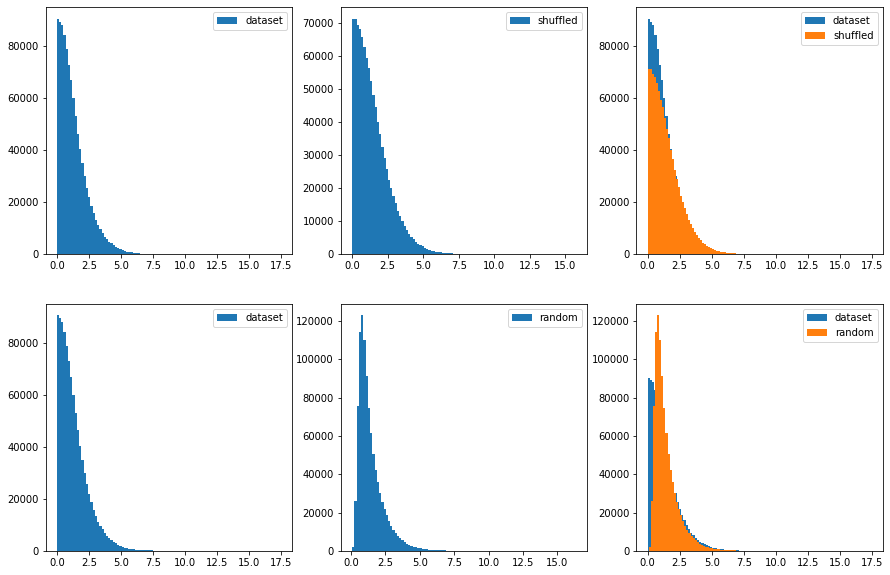

In [30]:
plt.subplot(2, 3, 1)
plt.hist(beta * bonus_1, bins = num_bins, label='dataset')
plt.legend()

plt.subplot(2, 3, 2)
plt.hist(beta * bonus_shuffled_1, bins = num_bins, label='shuffled')
plt.legend()

plt.subplot(2, 3, 3)
plt.hist(beta * bonus_1, bins = num_bins, label='dataset')
plt.hist(beta * bonus_shuffled_1, bins = num_bins, label='shuffled')
plt.legend(loc='upper right')


plt.subplot(2, 3, 4)
plt.hist(beta * bonus_1, bins = num_bins, label='dataset')
plt.legend()

plt.subplot(2, 3, 5)
plt.hist(beta * bonus_random_1_mean, bins = num_bins, label='random')
plt.legend()

plt.subplot(2, 3, 6)
plt.hist(beta * bonus_1, bins = num_bins, label='dataset')
plt.hist(beta * bonus_random_1_mean, bins = num_bins, label='random')
plt.legend(loc='upper right')

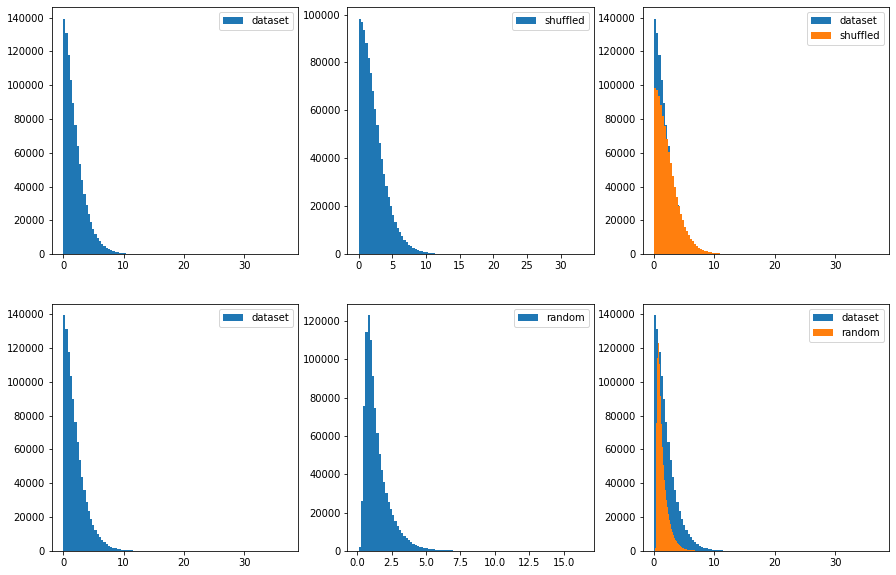

In [31]:
plt.subplot(2, 3, 1)
plt.hist(beta * bonus_2, bins = num_bins, label='dataset')
plt.legend()

plt.subplot(2, 3, 2)
plt.hist(beta * bonus_shuffled_2, bins = num_bins, label='shuffled')
plt.legend()

plt.subplot(2, 3, 3)
plt.hist(beta * bonus_2, bins = num_bins, label='dataset')
plt.hist(beta * bonus_shuffled_2, bins = num_bins, label='shuffled')
plt.legend(loc='upper right')


plt.subplot(2, 3, 4)
plt.hist(beta * bonus_2, bins = num_bins, label='dataset')
plt.legend()

plt.subplot(2, 3, 5)
plt.hist(beta * bonus_random_2_mean, bins = num_bins, label='random')
plt.legend()

plt.subplot(2, 3, 6)
plt.hist(beta * bonus_2, bins = num_bins, label='dataset')
plt.hist(beta * bonus_random_2_mean, bins = num_bins, label='random')
plt.legend(loc='upper right')

## normalizng the obs and actions

In [21]:
obs_normalized = (obs - obs.mean(axis=0)) / obs.std(axis=0)
actions_normalized = (actions - actions.mean(axis=0)) / actions.std(axis=0)

In [22]:
model_name_1 = 'Nov-25-2020_2036_walker2d-medium-v0.pt'
model_name_2 = 'Nov-23-2020_1150_walker2d-medium-v0.pt'

network_1, target_network_1 = load_models(model_name_1)
network_2, target_network_2 = load_models(model_name_2)

Loading model: ../models/Nov-25-2020_2036_walker2d-medium-v0.pt
Loading model: ../models/Nov-23-2020_1150_walker2d-medium-v0.pt


In [23]:
bonus_1 = get_bonus(obs, actions, network_1, target_network_1).detach().cpu().numpy()
bonus_2 = get_bonus(obs, actions, network_2, target_network_2).detach().cpu().numpy()

ind = np.random.permutation(actions.shape[0])
shuffled_actions = actions[ind]


bonus_shuffled_1 = get_bonus(obs, shuffled_actions, network_1, target_network_1).detach().cpu().numpy()
bonus_shuffled_2 = get_bonus(obs, shuffled_actions, network_2, target_network_2).detach().cpu().numpy()


In [24]:
random_actions = torch.FloatTensor(actions.shape[0] * num_random, actions.shape[-1]).uniform_(-1, 1)

bonus_random_1 = get_bonus_random_actions(obs, random_actions, network_1, target_network_1).detach().cpu().numpy()
bonus_random_1_mean = np.mean(bonus_random_1, axis=1)

bonus_random_2 = get_bonus_random_actions(obs, random_actions, network_2, target_network_2).detach().cpu().numpy()
bonus_random_2_mean = np.mean(bonus_random_1, axis=1)

In [32]:
reward_mean = np.mean(rewards)
delta_bonus_1 = abs(bonus_random_1_mean - bonus_1).squeeze(1)

delta_bonus_1_mean = np.mean(delta_bonus_1)
b_0 = 0.5
print('mean reward:{}, delta_bonus:{}'.format(reward_mean,delta_bonus_1_mean))
rho1 = reward_mean / delta_bonus_1_mean
beta1 = b_0 * rho1
print('beta1:{:.2g}, rho1:{:.2g}'.format(beta1, rho1))

rho2 = np.mean(rewards / np.clip(delta_bonus_1, 1e-9, 1e9))
beta2 = b_0 * rho2
print('beta2:{:.2g}, rho2:{:.2g}'.format(beta2, rho2))



mean reward:2.6488335132598877, delta_bonus:0.0003254744515288621
beta1:4.1e+03, rho1:8.1e+03
beta2:3.5e+04, rho2:7e+04


In [48]:
for b_0 in [0.1, 0.3, 0.5, 0.7]:
    print('beta1:{:.2g}'.format(b_0 * rho1))

beta1:8.1e+02
beta1:2.4e+03
beta1:4.1e+03
beta1:5.7e+03


In [49]:
for b_0 in [0.1, 0.3, 0.5, 0.7]:
    print('beta1:{:.2g}'.format(b_0 * rho2))

beta1:7e+03
beta1:2.1e+04
beta1:3.5e+04
beta1:4.9e+04


In [53]:
bonus_random_1_median = np.median(bonus_random_1, axis=1)

reward_median = np.median(rewards)
delta_bonus_1 = abs(bonus_random_1_median - bonus_1).squeeze(1)

delta_bonus_1_median = np.median(delta_bonus_1)
b_0 = 0.5
print('median reward:{}, delta_bonus:{}'.format(reward_median,delta_bonus_1_median))
rho1 = reward_median / delta_bonus_1_median
beta1 = b_0 * rho1
print('beta1:{:.2g}, rho1:{:.2g}'.format(beta1, rho1))

rho2 = np.median(rewards / np.clip(delta_bonus_1, 1e-9, 1e9))
beta2 = b_0 * rho2
print('beta2:{:.2g}, rho2:{:.2g}'.format(beta2, rho2))


median reward:3.02319598197937, delta_bonus:0.0002667059889063239
beta1:5.7e+03, rho1:1.1e+04
beta2:4.6e+03, rho2:9.3e+03


In [54]:
for b_0 in [0.1, 0.3, 0.5, 0.7]:
    print('beta1:{:.2g}'.format(b_0 * rho1))

beta1:1.1e+03
beta1:3.4e+03
beta1:5.7e+03
beta1:7.9e+03


In [55]:
for b_0 in [0.1, 0.3, 0.5, 0.7]:
    print('beta1:{:.2g}'.format(b_0 * rho2))

beta1:9.3e+02
beta1:2.8e+03
beta1:4.6e+03
beta1:6.5e+03


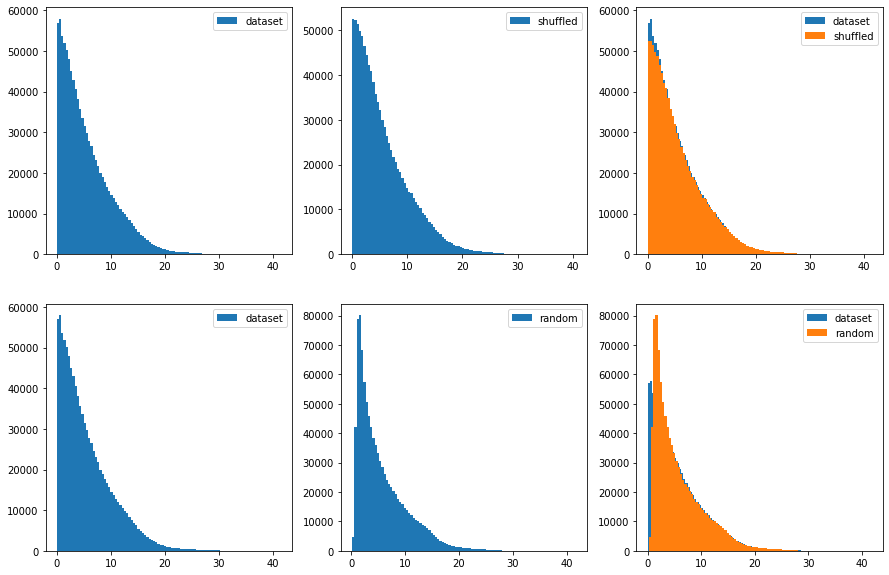

In [37]:
plt.subplot(2, 3, 1)
plt.hist(beta * bonus_1, bins = num_bins, label='dataset')
plt.legend()

plt.subplot(2, 3, 2)
plt.hist(beta * bonus_shuffled_1, bins = num_bins, label='shuffled')
plt.legend()

plt.subplot(2, 3, 3)
plt.hist(beta * bonus_1, bins = num_bins, label='dataset')
plt.hist(beta * bonus_shuffled_1, bins = num_bins, label='shuffled')
plt.legend(loc='upper right')


plt.subplot(2, 3, 4)
plt.hist(beta * bonus_1, bins = num_bins, label='dataset')
plt.legend()

plt.subplot(2, 3, 5)
plt.hist(beta * bonus_random_1_mean, bins = num_bins, label='random')
plt.legend()

plt.subplot(2, 3, 6)
plt.hist(beta * bonus_1, bins = num_bins, label='dataset')
plt.hist(beta * bonus_random_1_mean, bins = num_bins, label='random')
plt.legend(loc='upper right')

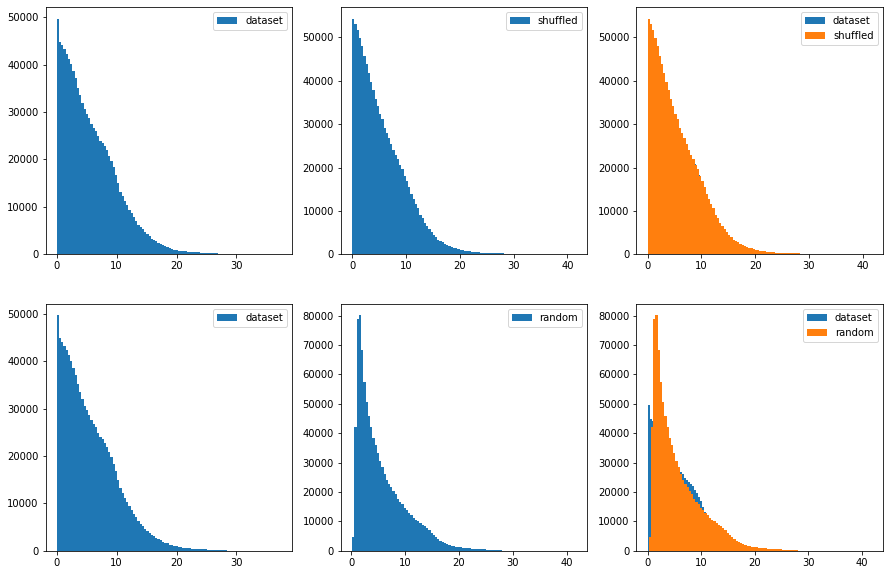

In [38]:
plt.subplot(2, 3, 1)
plt.hist(beta * bonus_2, bins = num_bins, label='dataset')
plt.legend()

plt.subplot(2, 3, 2)
plt.hist(beta * bonus_shuffled_2, bins = num_bins, label='shuffled')
plt.legend()

plt.subplot(2, 3, 3)
plt.hist(beta * bonus_2, bins = num_bins, label='dataset')
plt.hist(beta * bonus_shuffled_2, bins = num_bins, label='shuffled')
plt.legend(loc='upper right')


plt.subplot(2, 3, 4)
plt.hist(beta * bonus_2, bins = num_bins, label='dataset')
plt.legend()

plt.subplot(2, 3, 5)
plt.hist(beta * bonus_random_2_mean, bins = num_bins, label='random')
plt.legend()

plt.subplot(2, 3, 6)
plt.hist(beta * bonus_2, bins = num_bins, label='dataset')
plt.hist(beta * bonus_random_2_mean, bins = num_bins, label='random')
plt.legend(loc='upper right')